### Comparison of `MLP`, `Random-Search Tuned MLP`, `RandOver MLP`, `SPE MLP`

## The Method

1. Prepare data & Partition the data into 80-20 train-test split
2. Define Models & Parameters
3. Perform Cross-Validation on the training data
3. (Re)Train the models on the training data, either vanilla model or with best hyperparameters
4. Evaluate the (re)trained models on the test data
5. Final evaluation of the models

![The Method](method.png)

Source: [scikit-learn.org - Cross-validation](https://scikit-learn.org/1.5/modules/cross_validation.html#cross-validation-and-model-selection)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from pandas import DataFrame as df
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imblearn_pipeline # Use imblearn's pipeline
from sklearn.metrics import make_scorer, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import ML libraries
import keras
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imbens.ensemble import SelfPacedEnsembleClassifier
from scikeras.wrappers import KerasClassifier
import keras_tuner
from keras import layers

from pprint import pprint
from time import time
import joblib

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
CROSS_VAL_SPLITS = 5
CKP_PREFIX = 'KDD_'

np.random.seed(RANDOM_STATE)

# pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


### 1. Prepare data & Partition the data into 80-20 train-test split

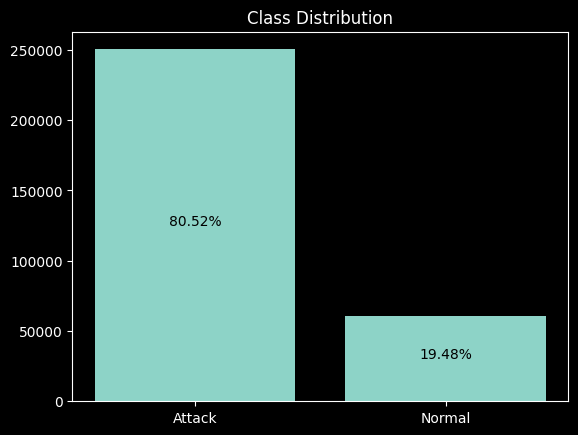

Weights:  {0: 4.991290198603437e-06, 1: 2.062961587655238e-05}
Transformed X_train shape: (248823, 121)


In [4]:
# Importing the dataset

path_to_data = '../data/kddcup/kddcup_data_corrected.csv'

# col names from https://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
col_names = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate",
    "label",
]
# from https://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
categorical_cols = [
    "protocol_type",
    "service",
    "flag",
    "land",
    "logged_in",
    "is_host_login",
    "is_guest_login",
]

# Read data (10 % subset of the original dataset)
data = pd.read_csv(path_to_data, names=col_names, header=None)

# summarize attack types as "attack" for binary classification
data["label"] = data["label"].apply(lambda x: "attack" if x != "normal." else 'normal')

# Split data sets into X, y respectively
X = data.drop("label", axis=1)
y = data["label"]

# Visualize class imbalance
plt.bar(["Attack", "Normal"], data["label"].value_counts())
total = len(data)
fraud_percentage = (data["label"].value_counts()[1] / total) * 100
normal_percentage = (data["label"].value_counts()[0] / total) * 100

plt.text(0, data["label"].value_counts()[0] / 2, f'{normal_percentage:.2f}%', ha='center', color='black')
plt.text(1, data["label"].value_counts()[1] / 2, f'{fraud_percentage:.2f}%', ha='center', color='black')
plt.title("Class Distribution")
plt.show()

# Encode labels (LabelEncoder is not part of the pipeline but applied directly to y)
le = LabelEncoder()
y = le.fit_transform(y)

# create training and test partitions with 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# Fit OneHotEncoder to learn categories from the training data. This is necessary to ensure that the same categories are used for random splits during cross-validation
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype="int8")
one_hot_encoder.fit(X_train[categorical_cols])
learned_categories = one_hot_encoder.categories_

# Define numerical columns & indices
num_cols = data.drop(categorical_cols, axis=1)
num_indices = [data.columns.get_loc(col) for col in num_cols.drop('label', axis=1).columns]
cat_indices = [data.columns.get_loc(col) for col in categorical_cols]

# Set class weights
class_weight = {label[0]: 1.0 / count for label, count in df(y_train).value_counts().items()}
print("Weights: ", class_weight)

# Define preprocessing transformers and pipeline

# Numerical transformer. Scales numerical data using StandardScaler
numeric_transformer = imblearn_pipeline(
    steps=[("scaler", StandardScaler())], verbose=False
)
numeric_transformer.set_output(transform="pandas")

# Categorical transformer. Encodes categorical data using OneHotEncoder
categorical_transformer = imblearn_pipeline(
    steps=[
        (
            "onehot",
            OneHotEncoder(
                handle_unknown="ignore",
                sparse_output=False,
                categories=learned_categories,
                dtype="int8",
            ),
        )
    ],
    verbose=False,
)
categorical_transformer.set_output(transform="pandas")

# Define preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_indices),
        ("cat", categorical_transformer, cat_indices),
    ],
    verbose=False,
)


# Check preprocessing pipeline and get target shape
transformed_sample = preprocessor.fit_transform(X_train)
print(f"Transformed X_train shape: {transformed_sample.shape}")

### 2. Define models and parameters

In [10]:
## Credits for model architecture: https://keras.io/examples/structured_data/imbalanced_classification/
## Try same model architecture on this dataset for comparison
def _mlp(name="mlp"):
    # Hyperparameters
    data_dim = transformed_sample.shape[1] # Number of features after preprocessing pipeline step
    batch_size = 2048
    epochs = 50
    learning_rate = 1e-2
    Adam = keras.optimizers.Adam(learning_rate)

    # Define model
    model = keras.Sequential(
        [
            keras.Input(shape=(data_dim,)),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(1, activation="sigmoid"),
        ]
    )

    # Define metrics
    metrics = [
        keras.metrics.F1Score(name="f1"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ]

    callbacks = [
        keras.callbacks.ModelCheckpoint(
            f"./ckp/{CKP_PREFIX}{name}/epoch_" + "{epoch}" + ".keras"
        )
    ]

    return KerasClassifier(
        model,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        loss="binary_crossentropy",
        callbacks=callbacks,
        metrics=metrics,
        optimizer=Adam,
        class_weight=class_weight,
        random_state=RANDOM_STATE,
    )


# Model for RandomSearchCV
def _random_search_mlp(
    input_units=256,
    input_activation="relu",
    dropout_input=False,
    dropout_input_rate=0.3,
    h1=False,
    h1_units=128,
    h1_activation="relu",
    dropout_h1=False,
    dropout_h1_rate=0.3,
    h2=False,
    h2_units=64,
    h2_activation="relu",
    dropout_h2=False,
    dropout_h2_rate=0.3,
    learning_rate=1e-2,
    name="rs_mlp",
    batch_size=2048,
    epochs=50,
):
    # print(f"Building model: {name}")
    # print('current params:', input_units, input_activation, dropout_input, dropout_input_rate, h1, h1_units, h1_activation, dropout_h1, dropout_h1_rate, h2, h2_units, h2_activation, dropout_h2, dropout_h2_rate, learning_rate, name, batch_size, epochs)
    data_dim = transformed_sample.shape[1] # Number of features after preprocessing pipeline step

    model = keras.Sequential()
    model.add(layers.Input(shape=(data_dim,), name="input"))
    model.add(
        layers.Dense(input_units, activation=input_activation, name="input_layer")
    )

    if dropout_input:
        model.add(layers.Dropout(dropout_input_rate))

    if h1:
        model.add(layers.Dense(h1_units, activation=h1_activation, name="h1"))
        if dropout_h1:
            model.add(layers.Dropout(dropout_h1_rate))

    if h2:
        model.add(layers.Dense(h2_units, activation=h2_activation, name="h2"))
        if dropout_h2:
            model.add(layers.Dropout(dropout_h2_rate))

    model.add(layers.Dense(1, activation="sigmoid", name="output"))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.F1Score(name="f1"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
        ],
    )
    return model


# KerasClassifier with create_model as build_fn
random_serach_keras_clf = KerasClassifier(
    build_fn=_random_search_mlp,
    verbose=0,
    random_state=RANDOM_STATE,
    input_units=256,
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    loss="binary_crossentropy",
    input_activation="relu",
    dropout_input=False,
    dropout_input_rate=0.3,
    h1=False,
    h1_units=128,
    h1_activation="relu",
    dropout_h1=False,
    dropout_h1_rate=0.3,
    h2=False,
    h2_units=64,
    h2_activation="relu",
    dropout_h2=False,
    dropout_h2_rate=0.3,
    learning_rate=1e-2,
    name="rs_mlp",
    batch_size=2048,
    epochs=50,
    class_weight=class_weight,
)

# Define pipelines
mlp_normal_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ("mlp", _mlp()),
    ]
)
print("MLP Normal pipeline:")
display(mlp_normal_pipeline)

# Define randomsearch pipeline
mlp_rs_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ("rs_tuned_mlp", random_serach_keras_clf),
    ]
)
print("RandomSearchCV MLP pipeline:")
display(mlp_rs_pipeline)

# Define multimetric scoring
scoring = {
    "f1": make_scorer(f1_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
}

# Define parameter grid
parameter_grid = {
    "rs_tuned_mlp__input_units": [64, 128, 256],
    "rs_tuned_mlp__input_activation": ["relu", "tanh"],
    "rs_tuned_mlp__dropout_input": [True, False],
    "rs_tuned_mlp__dropout_input_rate": [0.1, 0.3, 0.5],
    "rs_tuned_mlp__h1": [True, False],
    "rs_tuned_mlp__h1_units": [64, 128, 256],
    "rs_tuned_mlp__h1_activation": ["relu", "tanh"],
    "rs_tuned_mlp__dropout_h1": [True, False],
    "rs_tuned_mlp__dropout_h1_rate": [0.1, 0.3, 0.5],
    "rs_tuned_mlp__h2": [True, False],
    "rs_tuned_mlp__h2_units": [64, 128, 256],
    "rs_tuned_mlp__h2_activation": ["relu", "tanh"],
    "rs_tuned_mlp__dropout_h2": [True, False],
    "rs_tuned_mlp__dropout_h2_rate": [0.1, 0.3, 0.5],
    "rs_tuned_mlp__learning_rate": [1e-2, 0.01, 0.02, 0.03],
}

# Randomized search with k-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=mlp_rs_pipeline,
    param_distributions=parameter_grid,
    n_iter=10,  # Define the number of random samples to try
    scoring=scoring,
    refit="f1",  # Refit on F1 score after finding the best parameters
    cv=StratifiedKFold(n_splits=5),  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    error_score='raise',
)

MLP Normal pipeline:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 4, 5, 7, 8, 9, 10, 12, 13,
                                                   14, 15, 16, 17, 18, 19, 22,
                                                   23, 24, 25, 26, 27, 28, 29,
                                                   30, 31, 32, 33, 34, 35, 36, ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(categories=[array(['icmp', 'tcp', 'udp'], dtype=object),
                                                                                             array(['IRC', 'X11', 'Z39_50', 'auth', 'bgp', '...
                 KerasClassifier(batch_size=2048, callbacks=[<keras.src.callbacks.model_checkpoint.ModelCheckpoint object at 0x3309f2dd0>], class_weight={0: 4.991290198603437e-06, 1: 2.062961587655238e-05}, epochs=50, loss='binary_crossentropy', metrics=[<F1Score name=f1>, <Precision name=precision>, <Recall name=recall>], model=<Sequential name=sequential_4, built=True>, optimizer=<keras.src.optimizers.adam.Adam object at 0x32ef71790>, random_state=42, verbose=0))])

RandomSearchCV MLP pipeline:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 4, 5, 7, 8, 9, 10, 12, 13,
                                                   14, 15, 16, 17, 18, 19, 22,
                                                   23, 24, 25, 26, 27, 28, 29,
                                                   30, 31, 32, 33, 34, 35, 36, ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(categories=[array(['icmp', 'tcp', 'udp'], dtype=object),
                                                                                             array(['IRC', 'X11', 'Z39_50', 'auth', 'bgp', '...
                 KerasClassifier(batch_size=2048, build_fn=<function _random_search_mlp at 0x330169d00>, class_weight={0: 4.991290198603437e-06, 1: 2.062961587655238e-05}, dropout_h1=False, dropout_h1_rate=0.3, dropout_h2=False, dropout_h2_rate=0.3, dropout_input=False, dropout_input_rate=0.3, epochs=50, h1=False, h1_activation='relu', h1_units=128, h2=False, h2_activation='relu', h2_units=64, input_activation='relu', input_units=256, learning_rate=0.01, loss='binary_crossentropy', name='rs_mlp', optimizer=<keras.src.optimizers.adam.Adam object at 0x330b4b410>, random_state=42, verbose=0))])

### 3. Perform Cross-Validation on the training data

In [11]:
# Run random search on MLP and fit to training data
print("\nRunning RandomizedSearchCV for MLP...")
print("Hyperparameters to be evaluated:\n")
pprint(parameter_grid)

t0 = time()
random_search.fit(X_train, y_train)
print(
    f"\RandomizedSearchCV took {time() - t0:.2f} seconds ({(time() - t0) / 60:.2f} minutes)"
)

print("\nBest parameters combination found:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

# Best estimator from RandomizedSearchCV
best_mlp_model = random_search.best_estimator_

# save best model
joblib.dump(best_mlp_model, f"./saved/{CKP_PREFIX}best_mlp_model.pkl")



Running RandomizedSearchCV for MLP...
Hyperparameters to be evaluated:

{'rs_tuned_mlp__dropout_h1': [True, False],
 'rs_tuned_mlp__dropout_h1_rate': [0.1, 0.3, 0.5],
 'rs_tuned_mlp__dropout_h2': [True, False],
 'rs_tuned_mlp__dropout_h2_rate': [0.1, 0.3, 0.5],
 'rs_tuned_mlp__dropout_input': [True, False],
 'rs_tuned_mlp__dropout_input_rate': [0.1, 0.3, 0.5],
 'rs_tuned_mlp__h1': [True, False],
 'rs_tuned_mlp__h1_activation': ['relu', 'tanh'],
 'rs_tuned_mlp__h1_units': [64, 128, 256],
 'rs_tuned_mlp__h2': [True, False],
 'rs_tuned_mlp__h2_activation': ['relu', 'tanh'],
 'rs_tuned_mlp__h2_units': [64, 128, 256],
 'rs_tuned_mlp__input_activation': ['relu', 'tanh'],
 'rs_tuned_mlp__input_units': [64, 128, 256],
 'rs_tuned_mlp__learning_rate': [0.01, 0.01, 0.02, 0.03]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error i

\RandomizedSearchCV took 491.89 seconds (8.20 minutes)

Best parameters combination found:
rs_tuned_mlp__dropout_h1: True
rs_tuned_mlp__dropout_h1_rate: 0.5
rs_tuned_mlp__dropout_h2: False
rs_tuned_mlp__dropout_h2_rate: 0.5
rs_tuned_mlp__dropout_input: False
rs_tuned_mlp__dropout_input_rate: 0.1
rs_tuned_mlp__h1: False
rs_tuned_mlp__h1_activation: tanh
rs_tuned_mlp__h1_units: 128
rs_tuned_mlp__h2: True
rs_tuned_mlp__h2_activation: tanh
rs_tuned_mlp__h2_units: 64
rs_tuned_mlp__input_activation: relu
rs_tuned_mlp__input_units: 128
rs_tuned_mlp__learning_rate: 0.02


['./saved/KDD_best_mlp_model.pkl']

In [34]:
# Get the index of the best combination found by RandomizedSearchCV
best_index = random_search.best_index_

# Extract mean and std for each metric from the best estimator
f1_mean = random_search.cv_results_['mean_test_f1'][best_index]
f1_std = random_search.cv_results_['std_test_f1'][best_index]

precision_mean = random_search.cv_results_['mean_test_precision'][best_index]
precision_std = random_search.cv_results_['std_test_precision'][best_index]

recall_mean = random_search.cv_results_['mean_test_recall'][best_index]
recall_std = random_search.cv_results_['std_test_recall'][best_index]

# Display results with mean ± std deviation format
print("\nRnadomSearchCV Cross-Validation Results:")
print(f"F1 Score: {f1_mean:.4f} ± {f1_std:.4f}")
print(f"Precision: {precision_mean:.4f} ± {precision_std:.4f}")
print(f"Recall: {recall_mean:.4f} ± {recall_std:.4f}")

# create pipeline
best_mlp_model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ("best_mlp", best_mlp_model['rs_tuned_mlp']),
])


RnadomSearchCV Cross-Validation Results:
F1 Score: 0.9198 ± 0.0011
Precision: 0.8527 ± 0.0019
Recall: 0.9983 ± 0.0005


In [13]:
# 5-fold cross-validation for MLP Normal (copied architecture from CC notebook)
print(f"{CROSS_VAL_SPLITS}-fold cross-validation for MLP Normal:")

mlp_scores = cross_validate(
    mlp_normal_pipeline, X_train, y_train, 
    cv=StratifiedKFold(n_splits=CROSS_VAL_SPLITS), scoring=scoring, n_jobs=-1
)
mlp_scores_df = pd.DataFrame(mlp_scores)

# Print mean ± standard deviation of scores
print("\nMLP Normal Cross-Validation Results:")
for metric in scoring.keys():
    mean_score = mlp_scores_df[f'test_{metric}'].mean()
    std_score = mlp_scores_df[f'test_{metric}'].std()
    print(f"{metric}: {mean_score:.4f} ± {std_score:.4f}")

5-fold cross-validation for MLP Normal:

MLP Normal Cross-Validation Results:
f1: 0.9195 ± 0.0014
precision: 0.8521 ± 0.0025
recall: 0.9985 ± 0.0005


In [29]:
# RandomSearch tuned MLP reports better results than the MLP architure used in the creditcard notebook
# So we will use the best model from RandomSearchCV for RandomOverSampler and SelfPacedEnsembleClassifier

# Define RandOver pipeline
import copy


mlp_randover_pipeline = imblearn_pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "ros",
            RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy=1),
        ),  # This will handle oversampling
        ("randover_mlp", best_mlp_model['rs_tuned_mlp']),
    ]
)
mlp_randover_pipeline.set_output(transform="pandas")

display(mlp_randover_pipeline)

# Define SPE pipeline
mlp_spe_pipeline = imblearn_pipeline(
    steps = [
		("preprocessor", preprocessor),
        (
            "spe_mlp",
            SelfPacedEnsembleClassifier(
                random_state=RANDOM_STATE, estimator=best_mlp_model['rs_tuned_mlp']
            ),
        ),
    ]
)
mlp_spe_pipeline.set_output(transform="pandas")
display(mlp_spe_pipeline)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 4, 5, 7, 8, 9, 10, 12, 13,
                                                   14, 15, 16, 17, 18, 19, 22,
                                                   23, 24, 25, 26, 27, 28, 29,
                                                   30, 31, 32, 33, 34, 35, 36, ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(categories=[array(['icmp', 'tcp', 'udp'], dtype=object),
                                                                                             array(['IRC', 'X11', 'Z39_50', 'auth', 'bgp', '...
                 KerasClassifier(batch_size=2048, build_fn=<function _random_search_mlp at 0x330169d00>, class_weight={0: 4.991290198603437e-06, 1: 2.062961587655238e-05}, dropout_h1=True, dropout_h1_rate=0.5, dropout_h2=False, dropout_h2_rate=0.5, dropout_input=False, dropout_input_rate=0.1, epochs=50, h1=False, h1_activation='tanh', h1_units=128, h2=True, h2_activation='tanh', h2_units=64, input_activation='relu', input_units=128, learning_rate=0.02, loss='binary_crossentropy', name='rs_mlp', optimizer=<keras.src.optimizers.adam.Adam object at 0x3337dbd50>, random_state=42, verbose=0))])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 4, 5, 7, 8, 9, 10, 12, 13,
                                                   14, 15, 16, 17, 18, 19, 22,
                                                   23, 24, 25, 26, 27, 28, 29,
                                                   30, 31, 32, 33, 34, 35, 36, ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(categories=[array(['icmp', 'tcp', 'udp'], dtype=object),
                                                                                             array(['IRC', 'X11', 'Z39_50', 'auth', 'bgp', '...
                 SelfPacedEnsembleClassifier(estimator=KerasClassifier(batch_size=2048, build_fn=<function _random_search_mlp at 0x330169d00>, class_weight={0: 4.991290198603437e-06, 1: 2.062961587655238e-05}, dropout_h1=True, dropout_h1_rate=0.5, dropout_h2=False, dropout_h2_rate=0.5, dropout_input=False, dropout_input_rate=0.1, epochs=50, h1=False, h1_activation='tanh', h1_units=128, h2=True, h2_activation='tanh', h2_units=64, input_activation='relu', input_units=128, learning_rate=0.02, loss='binary_crossentropy', name='rs_mlp', optimizer=<keras.src.optimizers.adam.Adam object at 0x3337dbd50>, random_state=42, verbose=0),
                                             random_state=42))])

In [27]:
# 5-fold cross-validation for Random Oversampling
print(f"\n{CROSS_VAL_SPLITS}-fold cross-validation for MLP Random Oversampling:")
ros_mlp_scores = cross_validate(
    mlp_randover_pipeline, pd.DataFrame(X_train, columns=col_names), y_train,
    cv=StratifiedKFold(n_splits=CROSS_VAL_SPLITS), scoring=scoring, n_jobs=-1
)
ros_mlp_scores_df = pd.DataFrame(ros_mlp_scores)

print("\nRandom Oversampling:")
for metric in scoring.keys():
    mean_score = ros_mlp_scores_df[f'test_{metric}'].mean()
    std_score = ros_mlp_scores_df[f'test_{metric}'].std()
    print(f"{metric}: {mean_score:.4f} ± {std_score:.4f}")


5-fold cross-validation for MLP Random Oversampling:


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error i


Random Oversampling:
f1: 0.9188 ± 0.0015
precision: 0.8506 ± 0.0028
recall: 0.9990 ± 0.0004


In [31]:
# 5-fold cross-validation for Self-Paced Ensemble
print(f"\n{CROSS_VAL_SPLITS}-fold cross-validation for MLP Self-Paced Ensemble:")
spe_mlp_scores = cross_validate(
    mlp_spe_pipeline, X_train, y_train, 
    cv=StratifiedKFold(n_splits=CROSS_VAL_SPLITS), scoring=scoring, n_jobs=-1
)
spe_mlp_scores_df = pd.DataFrame(spe_mlp_scores)

print("\nSelf-Paced Ensemble:")
for metric in scoring.keys():
    mean_score = spe_mlp_scores_df[f'test_{metric}'].mean()
    std_score = spe_mlp_scores_df[f'test_{metric}'].std()
    print(f"{metric}: {mean_score:.4f} ± {std_score:.4f}")


5-fold cross-validation for MLP Self-Paced Ensemble:

Self-Paced Ensemble:
f1: 0.9199 ± 0.0014
precision: 0.8551 ± 0.0022
recall: 0.9954 ± 0.0011


### 4. (Re)Train the models on the training data

In [35]:
best_mlp_model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 4, 5, 7, 8, 9, 10, 12, 13,
                                                   14, 15, 16, 17, 18, 19, 22,
                                                   23, 24, 25, 26, 27, 28, 29,
                                                   30, 31, 32, 33, 34, 35, 36, ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(categories=[array(['icmp', 'tcp', 'udp'], dtype=object),
                                                                                             array(['IRC', 'X11', 'Z39_50', 'auth', 'bgp', '...
                 KerasClassifier(batch_size=2048, build_fn=<function _random_search_mlp at 0x330169d00>, class_weight={0: 4.991290198603437e-06, 1: 2.062961587655238e-05}, dropout_h1=True, dropout_h1_rate=0.5, dropout_h2=False, dropout_h2_rate=0.5, dropout_input=False, dropout_input_rate=0.1, epochs=50, h1=False, h1_activation='tanh', h1_units=128, h2=True, h2_activation='tanh', h2_units=64, input_activation='relu', input_units=128, learning_rate=0.02, loss='binary_crossentropy', name='rs_mlp', optimizer=<keras.src.optimizers.adam.Adam object at 0x3337dbd50>, random_state=42, verbose=0))])

In [36]:
# Retrain and time each model
# Placeholder dictionary for training times
training_times = {}

# Train MLP Normal (optional)
print("Training MLP Normal...")
start_time = time()
mlp_normal_pipeline.fit(X_train, y_train)
training_times['MLP Normal'] = time() - start_time

# Train best MLP model (from RandomSearchCV)
print("Training Best MLP (RandomSearchCV)...")
start_time = time()
best_mlp_model_pipeline.fit(X_train, y_train)
training_times['Best MLP (RandomSearchCV)'] = time() - start_time

# Train SPE MLP
print("Training SPE MLP...")
start_time = time()
mlp_spe_pipeline.fit(X_train, y_train)
training_times['SPE MLP'] = time() - start_time

# Train Random Oversampling MLP
print("Training Random Oversampling MLP...")
start_time = time()
mlp_randover_pipeline.fit(X_train, y_train)
training_times['Random Oversampling MLP'] = time() - start_time

# Report training times
print("Training Times for Each Model (in seconds):")
for model_name, training_time in training_times.items():
    print(f"{model_name}: {training_time:.2f} seconds")

# save all models
joblib.dump(mlp_normal_pipeline, f"./saved/{CKP_PREFIX}mlp_normal_pipeline.pkl")
joblib.dump(mlp_spe_pipeline, f"./saved/{CKP_PREFIX}mlp_spe_pipeline.pkl")
joblib.dump(mlp_randover_pipeline, f"./saved/{CKP_PREFIX}mlp_randover_pipeline.pkl")
joblib.dump(best_mlp_model_pipeline, f"./saved/{CKP_PREFIX}best_mlp_model_pipeline.pkl")

Training MLP Normal...
Training Best MLP (RandomSearchCV)...
Training SPE MLP...
Training Random Oversampling MLP...
Training Times for Each Model (in seconds):
MLP Normal: 75.28 seconds
Best MLP (RandomSearchCV): 21.21 seconds
SPE MLP: 443.25 seconds
Random Oversampling MLP: 31.44 seconds


['./saved/KDD_best_mlp_model_pipeline.pkl']

### 5. Final evaluation of the models


MLP Normal
F-1 Score: 0.9190
Precision: 0.8511
Recall: 0.9988

Best MLP Model (RandomSearchCV)
F-1 Score: 0.9174
Precision: 0.8479
Recall: 0.9993

SPE MLP
F-1 Score: 0.9185
Precision: 0.8527
Recall: 0.9953

RandOver MLP
F-1 Score: 0.9174
Precision: 0.8479
Recall: 0.9993


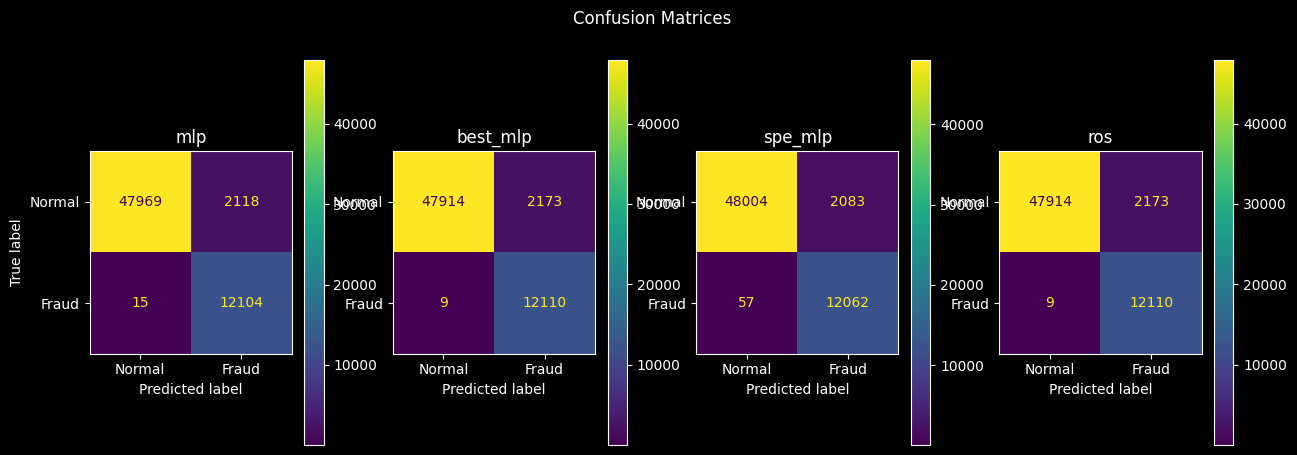

In [39]:
# evaluate each model on test set on f1, prec, recall and plot confusion matrix for each

# MLP Normal
y_test_pred = mlp_normal_pipeline.predict(X_test)
print("\nMLP Normal")
print(f"F-1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")

# Best MLP model (RandomSearchCV)
y_test_pred = best_mlp_model_pipeline.predict(X_test)
print("\nBest MLP Model (RandomSearchCV)")
print(f"F-1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")

# SPE MLP
y_test_pred = mlp_spe_pipeline.predict(X_test)
print("\nSPE MLP")
print(f"F-1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")

# Random Oversampling MLP
y_test_pred = mlp_randover_pipeline.predict(X_test)
print("\nRandOver MLP")
print(f"F-1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")

# Plot confusion matrix for each model
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
fig.suptitle("Confusion Matrices")
for i, model in enumerate([mlp_normal_pipeline, best_mlp_model_pipeline, mlp_spe_pipeline, mlp_randover_pipeline]):
	y_test_pred = model.predict(X_test)
	cm = confusion_matrix(y_test, y_test_pred)
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Fraud"])
	disp.plot(ax=axs[i])
	axs[i].set_title(model.steps[1][0])
plt.show()
